In [1]:
# https://planetarycomputer.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)

In [4]:
!pip install sarsen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.5/355.5 kB 4.4 MB/s eta 0:00:000:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.3/216.3 kB 19.7 MB/s eta 0:00:00


In [6]:
!pip install adlfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 1.9 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 6.4 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.7 MB/s eta 0:00:00
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 30.2 MB/s eta 0:00:00
  Using cached PyJWT-2.6.0-py3-none-any.whl (20 kB)
  Using cached portalocker-2.7.0-py2.py3-none-any.whl (15 kB)


In [7]:
import os
import tempfile

import rioxarray

from sarsen import apps

import adlfs
import planetary_computer
import pystac_client
import stackstac

In [8]:
# create a temporary directory where to store downloaded data
tmp_dir = tempfile.gettempdir()

# DEM path
dem_path = os.path.join(tmp_dir, "South-of-Redmond-10m.tif")

# path to Sentinel-1 input product in the Planetary Computer
product_folder = "GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048"  # noqa: E501

# band to be processed
measurement_group = "IW/VV"

tmp_dir

'/tmp'

In [9]:
lon, lat = [-121.95, 47.04]
buffer = 0.2
bbox = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]


In [10]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections="3dep-seamless", bbox=bbox, query={"gsd": {"eq": 10}}
)
items = search.item_collection()


In [11]:
dem_raster_all = stackstac.stack(items, bounds=bbox).squeeze()
dem_raster_all


<xarray.DataArray 'stackstac-14922e5cd24352457590fd5d72b6b2ec' (time: 4,
                                                                y: 4321, x: 4321)>
dask.array<getitem, shape=(4, 4321, 4321), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time             (time) datetime64[ns] 2018-02-02 2018-02-08 ... 2020-01-07
    id               (time) <U10 'n48w122-13' 'n47w122-13' ... 'n48w123-13'
    band             <U4 'data'
  * x                (x) float64 -122.2 -122.1 -122.1 ... -121.8 -121.8 -121.8
  * y                (y) float64 47.24 47.24 47.24 47.24 ... 46.84 46.84 46.84
    threedep:region  <U7 'n40w130'
    ...               ...
    proj:epsg        int64 5498
    proj:shape       object {10812}
    end_datetime     (time) <U20 '2016-12-31T00:00:00Z' ... '2019-04-25T00:00...
    start_datetime   (time) <U20 '1952-01-01T00:00:00Z' ... '2017-09-14T00:00...
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    epsg             int64 5498
Attributes:
    spec:        RasterSpec(epsg=5498, bounds=(-122.15000053746, 46.839907613...
    crs:         epsg:5498
    transform:   | 0.00, 0.00,-122.15|\n| 0.00,-0.00, 47.24|\n| 0.00, 0.00, 1...
    resolution:  9.2592593e-05

In [12]:
dem_raster_geo = dem_raster_all.compute()
if "time" in dem_raster_geo.dims:
    dem_raster_geo = dem_raster_geo.mean("time")
_ = dem_raster_geo.rio.set_crs(dem_raster_all.rio.crs)

In [13]:
# find the UTM zone and project in UTM
t_srs = dem_raster_geo.rio.estimate_utm_crs()
dem_raster = dem_raster_geo.rio.reproject(t_srs, resolution=(10, 10))

# crop DEM to our area of interest and save it
dem_corners = dict(x=slice(565000, 594000), y=slice(5220000, 5190000))


dem_raster = dem_raster.sel(**dem_corners)
dem_raster.rio.to_raster(dem_path)
dem_raster

<xarray.DataArray 'stackstac-14922e5cd24352457590fd5d72b6b2ec' (y: 3000, x: 2900)>
array([[ 196.68109131,  196.14202881,  194.11082458, ...,  820.71972656,
         820.05755615,  819.68597412],
       [ 196.68109131,  196.14202881,  194.11082458, ...,  817.84838867,
         814.0760498 ,  814.61773682],
       [ 197.03511047,  195.65205383,  195.13980103, ...,  812.12884521,
         810.13116455,  809.48669434],
       ...,
       [ 602.28057861,  607.78918457,  609.63909912, ..., 4130.93261719,
        4135.22167969, 4137.34033203],
       [ 597.96710205,  602.36712646,  603.93676758, ..., 4133.00195312,
        4137.37695312, 4139.43896484],
       [ 594.58496094,  599.09234619,  600.71466064, ..., 4135.22558594,
        4139.52978516, 4141.82373047]])
Coordinates:
  * x                (x) float64 5.65e+05 5.65e+05 ... 5.94e+05 5.94e+05
  * y                (y) float64 5.22e+06 5.22e+06 ... 5.19e+06 5.19e+06
    threedep:region  <U7 'n40w130'
    band             <U4 'data'
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    proj:epsg        int64 5498
    gsd              int64 10
    epsg             int64 5498
    proj:shape       object {10812}
    spatial_ref      int64 0
Attributes:
    _FillValue:  1.7976931348623157e+308

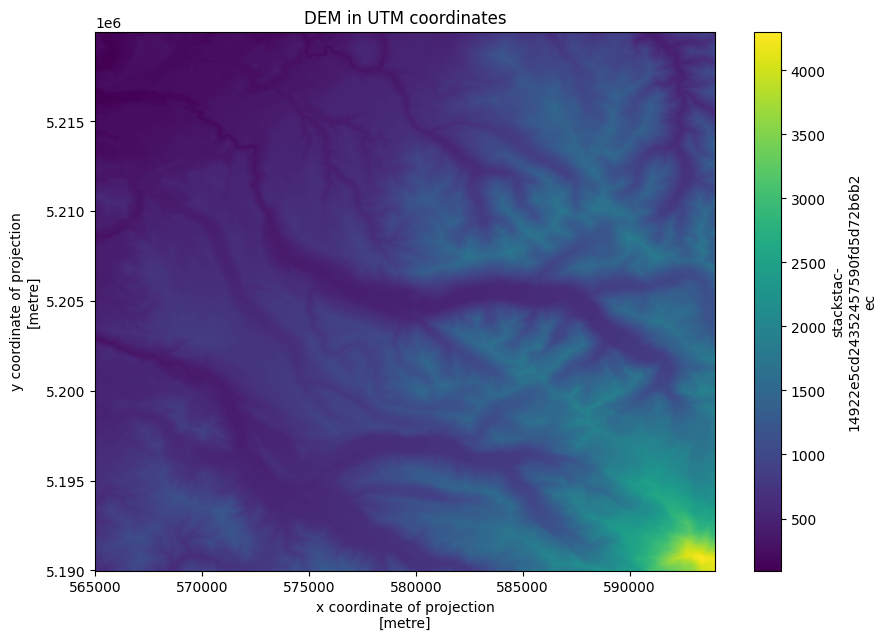

In [14]:
dem_raster.plot()
plt.title("DEM in UTM coordinates");

In [15]:
grd_account_name = "sentinel1euwest"
grd_storage_container = "s1-grd"
grd_product_folder = f"{grd_storage_container}/{product_folder}"
grd_local_path = os.path.join(tmp_dir, product_folder)

# Retrieve Sentinel-1 GRD


In [16]:
grd_token = planetary_computer.sas.get_token(
    grd_account_name, grd_storage_container
).token
grd_fs = adlfs.AzureBlobFileSystem(grd_account_name, credential=grd_token)
grd_fs.ls(f"{grd_product_folder}/manifest.safe")


['s1-grd/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048/manifest.safe']

In [17]:
grd_fs.get(grd_product_folder, grd_local_path, recursive=True)
!ls -d {grd_local_path}


/tmp/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048


# Processing

In [20]:
grd_local_path

'/tmp/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048'

In [32]:
from sarsen import apps
measurement_group= "IW/DV"
import sarsen

In [33]:
product = sarsen.Sentinel1SarProduct(
    "/tmp/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048",
    measurement_group="IW/VV",
    )


In [ ]:
#https://github.com/bopen/sarsen

In [39]:
output_path=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".10m.GTC.tif")
output_path

'/tmp/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048.10m.GTC.tif'

In [40]:
gtc = apps.terrain_correction(
    product,
    dem_urlpath=dem_path,
    output_urlpath=output_path,
)

In [41]:
output_urlpath

NameError: name 'output_urlpath' is not defined

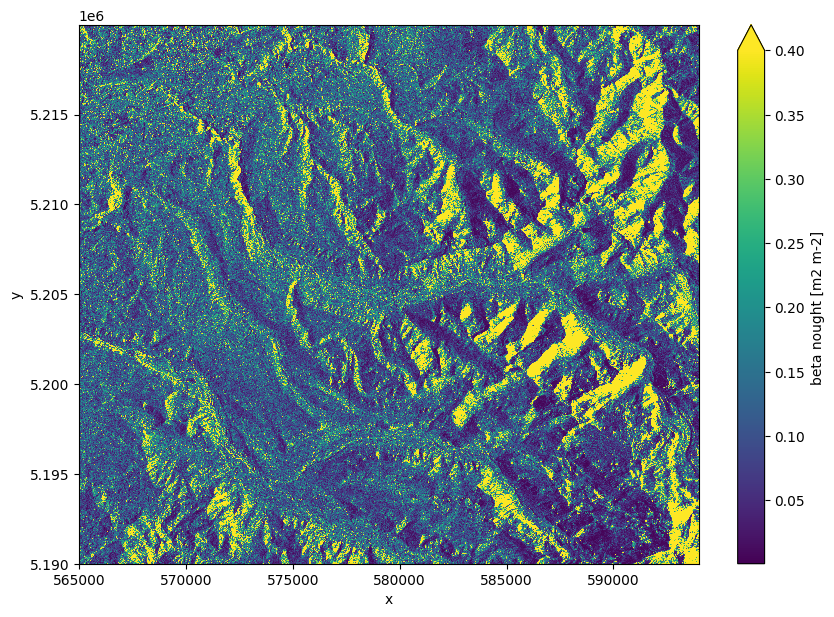

In [36]:
gtc.plot(vmax=0.4);
